# Overview

This study focuses on forecasting the next day's load using three different models. The models used are:

*  Baseline: Average of the load over the past 4 weeks.
*  TBATS Model: A time series forecasting model that incorporates multiple seasonalities and trend components.
*  SARIMAX with Fourier series: A seasonal autoregressive integrated moving average model enhanced with Fourier series for capturing seasonality.

Due to time constraints, the evaluation and prediction are limited to the last 7 days of data, rather than forecasting for every timestamp. Additionally, instead of using k-fold cross-validation, only one test set is used to simplify and expedite the process.

The evaluation metric chosen is the Mean Absolute Percentage Error (MAPE). The baseline approach yields the best results in terms of MAPE. Following that, the TBATS and SARIMAX models perform less promisingly.

Each section of the study provides detailed explanations of the models, including relevant assumptions, as well as any simplifications or omissions made due to time limitations.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import arma_order_select_ic
from tbats import TBATS
import pmdarima as pm

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('/content/load.csv')
data.head()

,0,load
0,2017-10-01 00:00:00,60.626609
1,2017-10-01 00:15:00,61.020288
2,2017-10-01 00:30:00,59.839250
3,2017-10-01 00:45:00,60.823449
4,2017-10-01 01:00:00,57.477175


In [ ]:
data.columns = ['dt', 'load']
data['dt'] = pd.to_datetime(data['dt'])
data['hour_of_day'] = data['dt'].dt.hour
data['day_of_week'] = data['dt'].dt.dayofweek
data['day_name'] = data['dt'].dt.day_name()
data.set_index('dt', inplace=True)

The hourly_data is created to improve the runtime of certain models. In order to compare the predicted results, each hourly prediction is evenly divided into four 15-minute intervals.

In [ ]:
hourly_data = data[['load']].resample('h').sum()

## Exploratory Data Analysis

In [ ]:
# check for duplicates in data
print('dt duplicates:', data.index.duplicated().sum())
print('#sample duplicates:', data.reset_index().duplicated().sum())

dt duplicates: 0
#sample duplicates: 0


In [ ]:
# check for missing values
assert data.isna().sum().sum() == 0

It is essential to verify the stationarity of our data since the majority of models assume it. The analysis reveals that the hourly/daily data exhibits stationarity, whereas the aggregated weekly/monthly data does not. Hence, it is not recommended to assume overall data stationarity.

In [ ]:
class TimeSeriesStationarityChecker:
    def __init__(self, time_series, significance_level=0.05):
        self.time_series = time_series
        self.significance_level = significance_level

    def check_stationarity(self):
        result = adfuller(self.time_series)

        adf_statistic = result[0]
        p_value = result[1]
        print('p-value:', round(p_value,2))

        if p_value < self.significance_level:
            print("Time series is stationary (reject null hypothesis)")
        else:
            print("Time series is not stationary (fail to reject null hypothesis)")

In [ ]:
df = hourly_data[['load']]
print('Hourly data')
checker = TimeSeriesStationarityChecker(df)
checker.check_stationarity()

Hourly data
p-value: 0.0
Time series is stationary (reject null hypothesis)


In [ ]:
df = data.resample('w').load.sum()
print('Weekly data')
checker = TimeSeriesStationarityChecker(df)
checker.check_stationarity()

Weekly data
p-value: 0.16
Time series is not stationary (fail to reject null hypothesis)


In [ ]:
df = data.resample('m').load.sum()
print('Monthly data')
checker = TimeSeriesStationarityChecker(df)
checker.check_stationarity()

Monthly data
p-value: 0.68
Time series is not stationary (fail to reject null hypothesis)


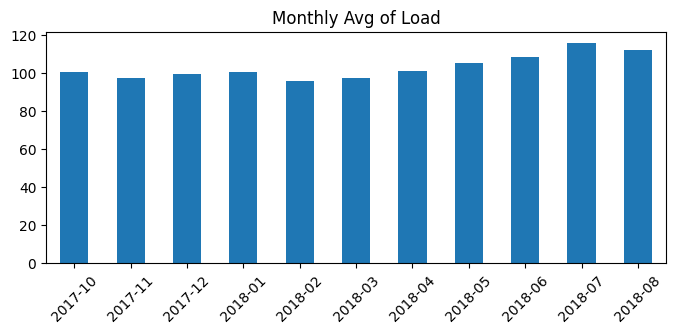

In [ ]:
df = data.resample('m').load.mean().reset_index()
df['Month'] = df.reset_index().dt.dt.to_period('M')
df.plot(x='Month', y='load', kind='bar', figsize=(8,3))
plt.title('Monthly Avg of Load')
plt.xlabel('')
plt.xticks(rotation=45)
plt.legend().remove()
plt.show()

The autocorrelation function (ACF) analysis reveals a distinct hourly seasonality in the data. The ACF plot illustrates the correlation between each observation and its lagged values, indicating the strength and pattern of the seasonality. In our case, the ACF plot demonstrates a clear cyclic pattern repeating on an hourly basis.

Furthermore, upon examining the load pattern during the week, we observe a consistent decrease in load on Thursdays and Fridays. This observation is evident in the figure below.

By identifying these patterns in the data, we gain insights into the underlying characteristics and temporal variations, allowing us to make more informed decisions and tailor our forecasting models accordingly.



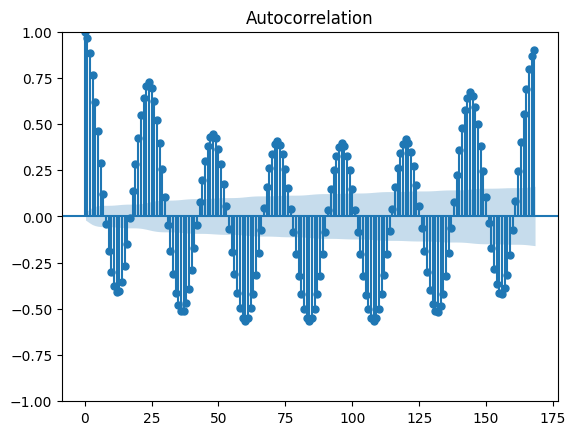

In [ ]:
plot_acf(hourly_data.load, lags=24*7);

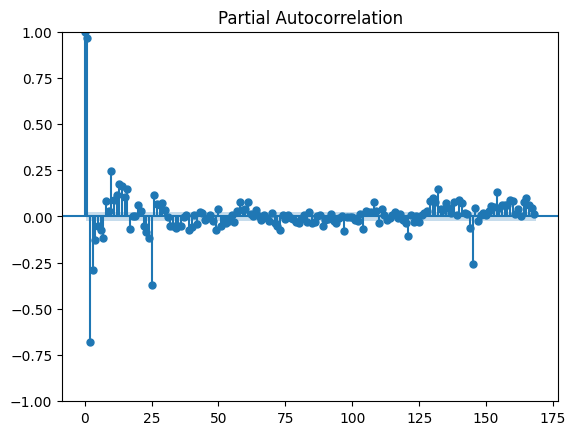

In [ ]:
plot_pacf(hourly_data.load, lags=24*7);

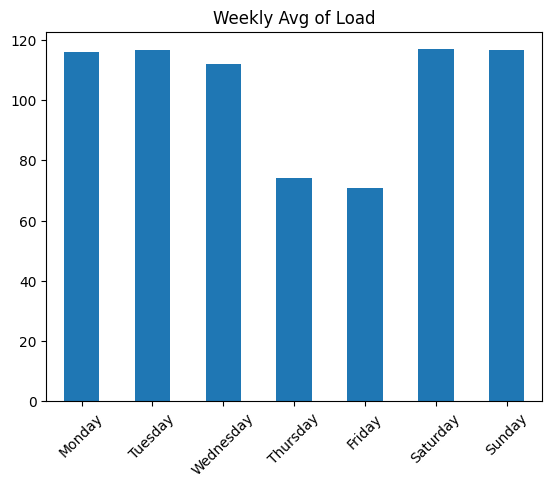

In [ ]:
data.groupby('day_name').mean().sort_values('day_of_week')['load'].plot(kind='bar')
plt.title('Weekly Avg of Load')
plt.xticks(rotation=45)
plt.xlabel('')
plt.legend().remove()
plt.show()

# Models

The train-test split is implemented differently based on the speed of the models being used. Faster models utilize a time interval of 15 minutes, while slower models make predictions using aggregated hourly data.

Regarding the evaluation of model performance, three metrics are calculated:

* Mean Absolute Percentage Error (MAPE)
* Mean Squared Error (MSE)
* Root Mean Squared Error (RMSE)

The choice between MAPE and MSE depends on the specific business problem at hand. If minimizing the overall error (particularly penalizing larger deviations more) is a priority, MSE is typically preferred. However, if the goal is to minimize the percentage deviation from the actual values, MAPE is chosen.

To ensure a fair comparison across models, the hourly data is uniformly divided into four 15-minute intervals when evaluating the slower models. This division allows for consistent assessment and comparison of the model's performance across different time intervals.

In [ ]:
# split train-test
train = data[['load']][:-96*7]
test = data[['load']][-96*7:]

htrain = hourly_data[:-24*7]
htest = hourly_data[-24*7:]

In [ ]:
# helper function for model evaluation and comparison
def metric_error(pred, test):
  mse = mean_squared_error(test, pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(test, pred)

  print("Mean Squared Error: ", round(mse, 2))
  print("Root Mean Squared Error: ", round(rmse, 2))
  print("Mean Absolute Percentage Error: ", round(mape, 2))

In [ ]:
# helper function for plotting actual vs predicted values
def plot_error(pred, test, index=None):
  if index is not None:
    pred = pd.DataFrame(pred, index=index)
  plt.plot(test, label='Actual')
  plt.plot(pred, label='Predicted')
  plt.xticks(rotation=45)
  plt.legend()
  plt.show()

## Baseline

The baseline forecast is determined by calculating the average of the load over the past four weeks. While it was possible to consider different time periods such as the last 2, 3, or 5 weeks, a four-week average was chosen for simplicity and to capture the monthly pattern in the model.

By taking the average load over the four-week period, the baseline forecast provides a reference point for comparison with more sophisticated forecasting models.

In [ ]:
new_data = data[['load']].copy()

In [ ]:
# last four weeks average
for i in range(1,5):
  new_data['l'+str(i)+'w'] = new_data.load.shift(96*7*i)
new_data['baseline_pred'] = (new_data['l1w'] + new_data['l2w'] + new_data['l3w'] + new_data['l4w'])/4

In [ ]:
metric_error(new_data[-96*7:]['baseline_pred'], new_data[-96*7:].load)

Mean Squared Error:  54.35
Root Mean Squared Error:  7.37
Mean Absolute Percentage Error:  0.04


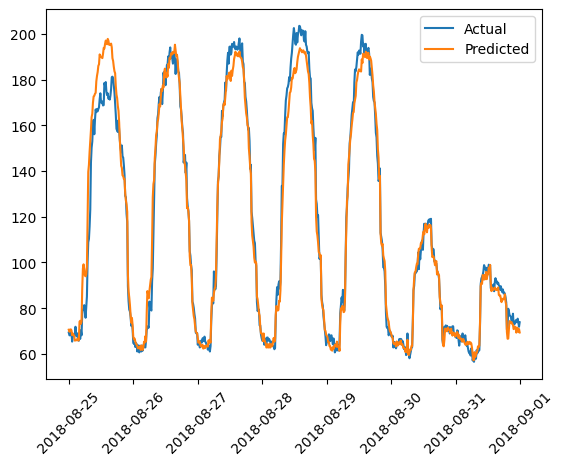

In [ ]:
plot_error(new_data[-96*7:]['baseline_pred'], new_data[-96*7:].load)

## TBATS

We are utilizing the TBATS model due to the clear presence of hourly and weekly seasonality patterns in our data. The TBATS model effectively captures these patterns by combining exponential smoothing techniques and trigonometric functions. It decomposes the time series into trend, seasonality, and error components, enabling accurate forecasts.

Despite its computational expense and longer runtime, the TBATS model achieves superior results compared to SARIMAX and demonstrates enhanced predictive capabilities, particularly when dealing with datasets featuring multiple seasonalities.

In [ ]:
%%time
estimator = TBATS(seasonal_periods=(24, 24*7),
                  use_arma_errors=False,  # shall try only models without ARMA
                  use_box_cox=False  # will not use Box-Cox
                  )
tbats_model = estimator.fit(htrain.load)

CPU times: user 45.3 s, sys: 854 ms, total: 46.1 s
Wall time: 15min 38s


In [ ]:
# Forecast 7 days ahead
tbats_pred = tbats_model.forecast(steps=24*7)

In [ ]:
metric_error(np.repeat(tbats_pred/4, 4), test.load.values)

Mean Squared Error:  300.19
Root Mean Squared Error:  17.33
Mean Absolute Percentage Error:  0.15


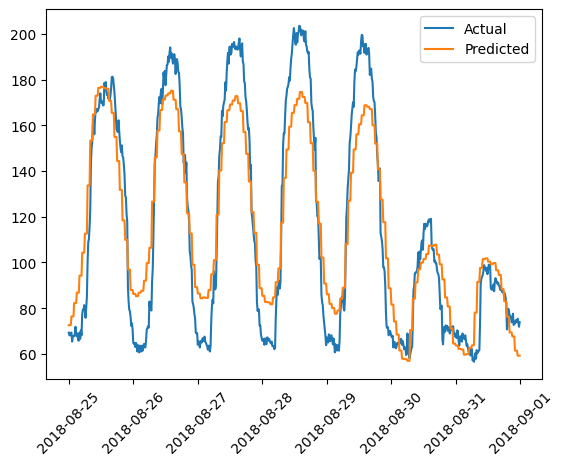

In [ ]:
plot_error(np.repeat(tbats_pred/4, 4), test.load, test.index)

## SARIMAX

The SARIMAX model is employed as the final model in our study, utilizing Fourier series to capture multiple seasonalities. Typically, SARIMAX models are designed to handle a single seasonality; however, we leverage Fourier series to model the weekly seasonal components.

Additionally, we utilize the Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC) to determine the optimal hyperparameters for the model. It is important to note that the BIC imposes a higher penalty for additional parameters compared to the AIC. As a result, the AIC is more prone to selecting overfit models, while the BIC tends to favor underfit models. Thus, considering both criteria can provide valuable insights when choosing the most appropriate model.

In [ ]:
arma_order_select_ic(htrain.load, max_ar = 4, max_ma = 3, ic= 'aic')

{'aic':                0             1             2             3
 0  102387.829255  93354.775906  86741.773557  83157.644755
 1   81328.231428  78680.627338  77582.395559  76838.979580
 2   76483.477383  75616.393422  75618.390173  75620.390142
 3   75801.636373  75618.390194  75401.434326  75401.890472
 4   75672.872865  75620.390096  75421.957339  75353.018093,
 'aic_min_order': (4, 3)}

In [ ]:
arma_order_select_ic(htrain.load, max_ar = 4, max_ma = 3, ic= 'bic')

{'bic':                0             1             2             3
 0  102401.771390  93375.689108  86769.657827  83192.500093
 1   81349.144630  78708.511608  77617.250896  76880.805985
 2   76511.361653  75651.248759  75660.216578  75669.187614
 3   75836.491710  75660.216599  75450.231798  75457.659012
 4   75714.699270  75669.187568  75477.725878  75415.757700,
 'bic_min_order': (4, 3)}

In [ ]:
# prepare Fourier terms
exog = pd.DataFrame({'dt': hourly_data.index})
exog['sin_weekly'] = np.sin(2 * np.pi * exog.dt.dt.dayofweek / 7*24)
exog['cos_weekly'] = np.cos(2 * np.pi * exog.dt.dt.dayofweek / 7*24)
exog['sin_weekly_2'] = np.sin(4 * np.pi * exog.dt.dt.dayofweek / 7*24)
exog['cos_weekly_2'] = np.cos(4 * np.pi * exog.dt.dt.dayofweek / 7*24)
exog['sin_hourly'] = np.sin(2 * np.pi * exog.dt.dt.hour)
exog['cos_hourly'] = np.cos(2 * np.pi * exog.dt.dt.hour)
exog['sin_hourly_2'] = np.sin(4 * np.pi * exog.dt.dt.hour)
exog['cos_hourly_2'] = np.cos(4 * np.pi * exog.dt.dt.hour)
exog = exog.set_index('dt')
exog_to_train = exog.iloc[:-24*7]
exog_to_test = exog.iloc[-24*7:]

Due to the slow runtime, the hyperparameter search step for SARIMAX has been skipped.

In [ ]:
# %%time
# SARIMA_model = pm.auto_arima(train["load"], start_p=1, start_q=1,
#                          test='adf',
#                          max_p=3, max_q=3,
#                          exogenous= exog_to_train,
#                          m=24,
#                          start_P=0,
#                          seasonal=True,
#                          d=None,
#                          D=1,
#                          trace=False,
#                          information_criterion='aic',
#                          error_action='ignore',
#                          suppress_warnings=True,
#                          stepwise=True)
# SARIMA_model

In [ ]:
%%time
sarimax_estimator = SARIMAX(htrain['load'],
                            order=(2, 1, 0),
                            seasonal_order=(1, 0, 1, 24),
                            exog=exog_to_train)

sarimax_model = sarimax_estimator.fit()

CPU times: user 2min 29s, sys: 1min 22s, total: 3min 52s
Wall time: 2min 43s


In [ ]:
sarimax_perd = sarimax_model.get_forecast(steps=24*7, exog=exog_to_test).predicted_mean

In [ ]:
metric_error(np.repeat(sarimax_perd/4, 4), test.load.values)

Mean Squared Error:  872.15
Root Mean Squared Error:  29.53
Mean Absolute Percentage Error:  0.2


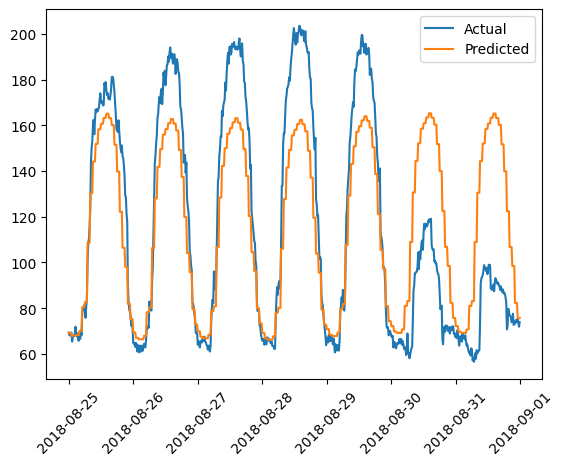

In [ ]:
plot_error(np.repeat(sarimax_perd.values/4, 4), test.load, test.index)

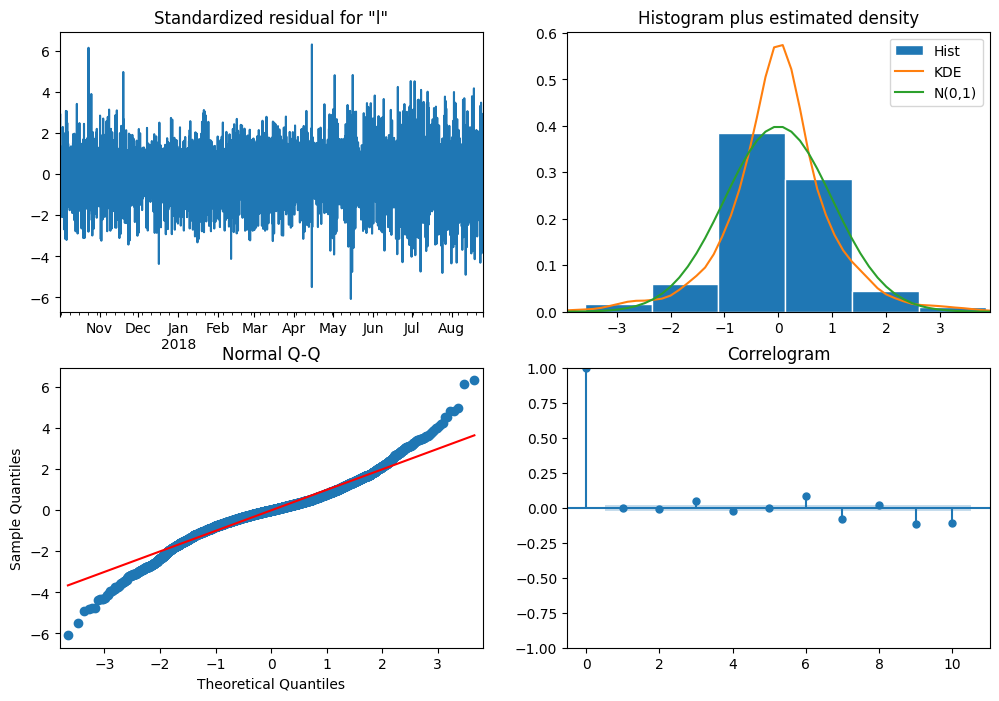

In [ ]:
# the Q_Q is almost on a straight line and no pattern in residuals
sarimax_model.plot_diagnostics(figsize=(12,8));

# Conclusion and Nest Steps

In conclusion, the baseline approach achieved the lowest MAPE, surpassing other models considering the train-test split method. However, there are certain factors that were not addressed in this study, including:

* Although the data clearly indicates lower loads on holidays compared to regular days, this study did not account for this factor. To enhance accuracy, incorporating holiday calendars as additional inputs or supplementary information for the models could be beneficial.

* Generally, utilizing more granular data would enhance accuracy. However, due to computational limitations, some models employed aggregated hourly data.

* This study did not conduct a hyperparameter search for the SARIMAX model or determine the optimal number of Fourier series. Allocating time to optimize these parameters could lead to better results for the model.



# ..................

# Appendix

Two additional approaches, Facebook Prophet and vanilla LSTM models, are investigated in this section.



*   Facebook Prophet
*   Vanilla LSTM



The Prophet model is relatively easy to implement and yields satisfactory results. On the other hand, the deep learning approach, demands more extensive efforts, including experimenting with different model architectures, exploring various input configurations, incorporating validation sets to avoid overfitting, and so on.



In [ ]:
df = pd.read_csv('/content/load.csv')
df.columns = ['dt','load']
df['dt'] = pd.to_datetime(df['dt'])
df.set_index('dt', inplace=True)

### Facebook Prophet

In [ ]:
from prophet import Prophet

In [ ]:
df = pd.read_csv('/content/load.csv')
df.columns = ['ds', 'y']

In [ ]:
m = Prophet()
m.add_seasonality(name='hourly', period=1/96, fourier_order=5)
m.add_seasonality(name='weekly', period=7, fourier_order=5)
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp5vw447m/zptncpv1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp5vw447m/u2rd16ra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75838', 'data', 'file=/tmp/tmpp5vw447m/zptncpv1.json', 'init=/tmp/tmpp5vw447m/u2rd16ra.json', 'output', 'file=/tmp/tmpp5vw447m/prophet_modelrxjyx5gl/prophet_model-20230525085713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:57:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:57:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=96, freq='15min')
forecast = m.predict(future)
forecast.set_index('ds', inplace=True)

In [ ]:
metric_error(forecast[-672-96:-96].yhat, test.load)

Mean Squared Error:  458.53
Root Mean Squared Error:  21.41
Mean Absolute Percentage Error:  0.19


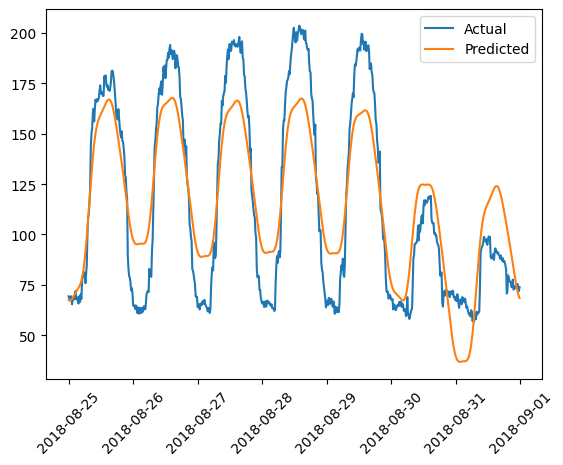

In [ ]:
plot_error(forecast[-672-96:-96].yhat, test.load)

### Vanilla LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

class EnergyLoadPredictor:
    def __init__(self):
        self.model = None
        self.scaler = MinMaxScaler()

    def preprocess_data(self, data):
        # Add time of the day and day of the week as additional parameters
        data['hour_of_day'] = data.index.hour
        data['day_of_week'] = data.index.dayofweek

        # Normalize the data
        normalized_data = self.scaler.fit_transform(data.values)

        return normalized_data

    def prepare_train_data(self, data, n_steps):
        X_train = []
        y_train = []

        for i in range(n_steps, len(data)):
            X_train.append(data[i-n_steps:i, :])
            y_train.append(data[i, 0])

        X_train, y_train = np.array(X_train), np.array(y_train)
        return X_train, y_train

    def build_model(self, n_steps):
        model = Sequential()
        model.add(LSTM(64,
                       activation='relu',
                       input_shape=(n_steps, 3)))
        model.add(Dense(1))
        model.compile(optimizer='adam',
                      loss='mean_squared_error')
        self.model = model

    def train_model(self, X_train, y_train, epochs, batch_size):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    def predict_next_values(self, train_data, n_steps, num_steps):
        # Get the last n_steps values from the training data
        last_n_steps = train_data[-n_steps:]

        # Reshape the data to match the input shape of the LSTM model
        X_pred = np.array([last_n_steps])
        X_pred = X_pred.reshape(-1, n_steps, 3)

        # Predict the next values step by step
        predicted_values = []

        for _ in range(num_steps):
            # Make prediction for the next step
            next_value = self.model.predict(X_pred, verbose=0)

            # Append predicted value to the list
            predicted_values.append(
                self.scaler.inverse_transform(
                    np.repeat(next_value, 3, axis=1))[0, 0])

            # Shift input sequence by one step and append the predicted value
            X_pred = np.roll(X_pred, -1, axis=1)
            X_pred[0, -1, 0] = next_value

        return predicted_values

    def plot_predictions(self, actual_values, predicted_values):
        plt.plot(actual_values, label='Actual')
        plt.plot(predicted_values, label='Predicted')
        plt.ylabel('Load')
        plt.title('Predicted vs Actual Load')
        plt.legend()
        plt.show()

In [ ]:
predictor = EnergyLoadPredictor()

normalized_data = predictor.preprocess_data(data[['load']].copy())
# Use data from the past year, excluding the last 7 days (672 intervals)
train_data = normalized_data[:-672]
X_train, y_train = predictor.prepare_train_data(train_data, n_steps=96)

predictor.build_model(n_steps=96)
predictor.train_model(X_train, y_train, epochs=3, batch_size=32)

Epoch 1/3
981/981 [==============================] - 51s 50ms/step - loss: 0.0041
Epoch 2/3
981/981 [==============================] - 46s 47ms/step - loss: 7.2859e-04
Epoch 3/3
981/981 [==============================] - 47s 48ms/step - loss: 6.0943e-04


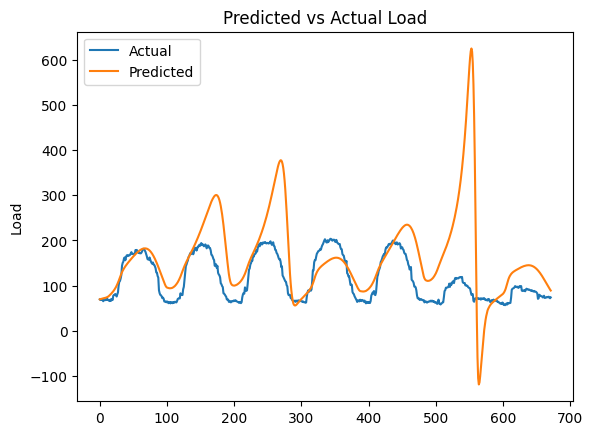

In [ ]:
predicted_values = predictor.predict_next_values(train_data,
                                                 n_steps=96,
                                                 num_steps=672)

predictor.plot_predictions(data[-672:].load.values, predicted_values)

In [ ]:
metric_error(predicted_values, test.load)

Mean Squared Error:  9964.97
Root Mean Squared Error:  99.82
Mean Absolute Percentage Error:  0.62
